In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import time
import math
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

%matplotlib inline
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [3]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

# Data Import

In [4]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('./%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [5]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

# Question 1 - Data Preprocessing

Removing Source column since its useless and passing only language data.

In [6]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

# load dataset using pandas
df = pd.read_csv('./ita.txt', sep='\t', header=None)
df.columns = ['ENG', 'IT', 'Source']
df = df.drop('Source', axis=1)
display(df.head())

# save only language data
df.to_csv('eng-it.txt', sep = '\t', index=False)

input_lang, output_lang, pairs = prepareData('eng', 'it', True)
print(random.choice(pairs))

Reading lines...
Read 341555 sentence pairs
Trimmed to 31079 sentence pairs
Counting words...
Counted words:
it 5260
eng 3091
['e un tennista vero ?', 'you re a tennis player aren t you ?']


In [58]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [59]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [60]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [61]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [62]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [63]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [64]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [65]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [66]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [67]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

# Question 2

There are 5 experiments conducted for model refinement. Each experiment evaluates the effect of hidden size or increase in hidden layers or different dropout rate or evaluates on different lanuage during test time.
Lot of scrolling down.. sorry. :)

# Experiment 1

Playing with hidden size of 128 but with a twist. The evaluation function uses Italian sentences as input and outputs English sentences.

2m 55s (- 41m 2s) (5000 6%) 2.9996
5m 39s (- 36m 48s) (10000 13%) 2.4498
8m 33s (- 34m 14s) (15000 20%) 2.1864
11m 28s (- 31m 33s) (20000 26%) 1.9646
14m 17s (- 28m 35s) (25000 33%) 1.8089
17m 7s (- 25m 41s) (30000 40%) 1.7111
20m 6s (- 22m 58s) (35000 46%) 1.5734
23m 0s (- 20m 8s) (40000 53%) 1.5230
25m 53s (- 17m 15s) (45000 60%) 1.4372
28m 46s (- 14m 23s) (50000 66%) 1.3587
31m 37s (- 11m 30s) (55000 73%) 1.3103
34m 33s (- 8m 38s) (60000 80%) 1.2820
37m 26s (- 5m 45s) (65000 86%) 1.2113
40m 19s (- 2m 52s) (70000 93%) 1.1755
43m 10s (- 0m 0s) (75000 100%) 1.1312


<Figure size 432x288 with 0 Axes>

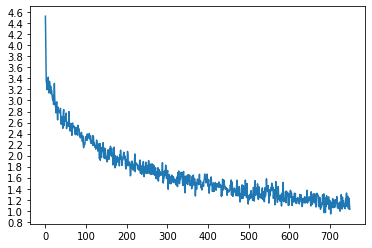

In [17]:
hidden_size = 128
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

In [18]:
evaluateRandomly(encoder1, attn_decoder1)

> io sono grata .
= i m grateful .
< i m jealous . <EOS>

> sei mia amica .
= you are my friend .
< you are my friend . <EOS>

> sono ancora indecisa .
= i m undecided as of yet .
< i m still married . <EOS>

> non sono tagliata per questo .
= i m not cut out for this .
< i m not at all for this . <EOS>

> lui e un eroe ignoto .
= he is an unsung hero .
< he s a pretty liar . <EOS>

> io non sto facendo questo per lei .
= i m not doing this for you .
< i m not doing this for you . <EOS>

> e cosi magra .
= you re so skinny .
< you re so romantic . <EOS>

> sono abituato ad essere ignorato .
= i m used to being ignored .
< i m used to be realistic . <EOS>

> sono ancora un dilettante .
= i m still an amateur .
< i m still a bad . <EOS>

> lei deve essere dalla mia parte .
= you re supposed to be on my side .
< you re supposed to be my wrong . <EOS>



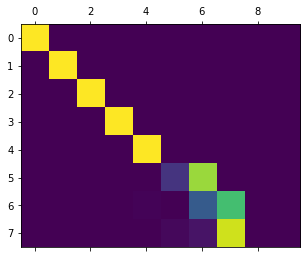

In [20]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "sono abituato ad essere ignorato .")
plt.matshow(attentions.numpy())

input = io non difendero tom .
output = i m not going to tom . <EOS>


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()


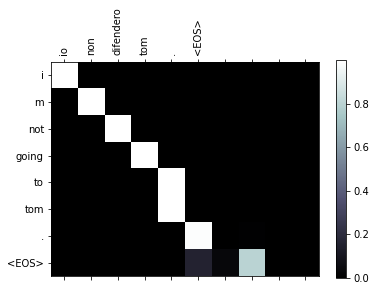

input = sono serio stavolta .
output = i m serious this . <EOS>


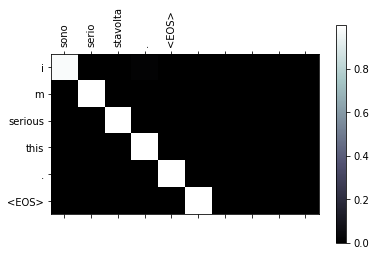

input = io non ho piu paura di voi .
output = i m not scared of you . <EOS>


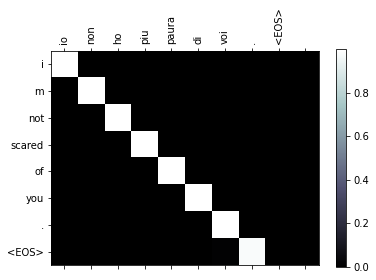

input = tu non stai lavorando abbastanza duramente .
output = you re not working hard enough . <EOS>


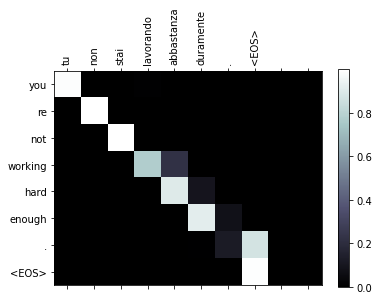

In [47]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention(random.choice(pairs)[0])

evaluateAndShowAttention(random.choice(pairs)[0])

evaluateAndShowAttention(random.choice(pairs)[0])

evaluateAndShowAttention(random.choice(pairs)[0])

# Experiment 2

Same experiment as above. Everything is same but number of hidden neurons is 256 now.

2m 59s (- 41m 48s) (5000 6%) 2.8891
5m 51s (- 38m 6s) (10000 13%) 2.2290
8m 46s (- 35m 4s) (15000 20%) 1.8961
11m 38s (- 32m 2s) (20000 26%) 1.6721
14m 37s (- 29m 14s) (25000 33%) 1.4804
17m 29s (- 26m 14s) (30000 40%) 1.3313
20m 24s (- 23m 19s) (35000 46%) 1.2195
23m 19s (- 20m 24s) (40000 53%) 1.0981
26m 13s (- 17m 28s) (45000 60%) 1.0145
29m 9s (- 14m 34s) (50000 66%) 0.9118
32m 2s (- 11m 39s) (55000 73%) 0.8745
35m 3s (- 8m 45s) (60000 80%) 0.7927
38m 3s (- 5m 51s) (65000 86%) 0.7450
41m 2s (- 2m 55s) (70000 93%) 0.6940
44m 2s (- 0m 0s) (75000 100%) 0.6438
> sono perfettamente felice qui .
= i m perfectly happy here .
< i m really happy here . <EOS>

> tu sei un tale codardo .
= you re such a coward .
< you re such a coward . <EOS>

> io sono analitico .
= i m analytical .
< i m resourceful . <EOS>

> io sto leggendo un libro sulle lingue .
= i m reading a book about languages .
< i m reading a book . <EOS>

> io sono un amica di tom .
= i m a friend of tom s .
< i m a of of tom to

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()


<Figure size 432x288 with 0 Axes>

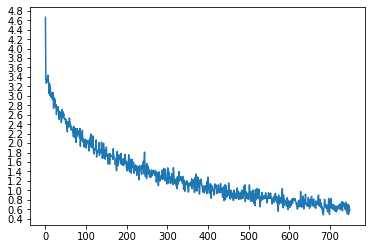

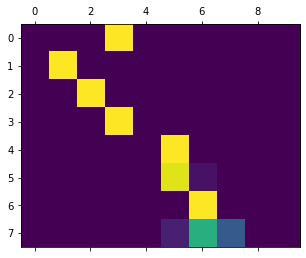

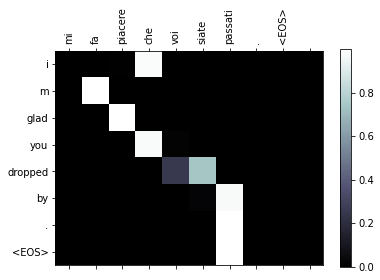

input = non sono qui per una vacanza .
output = i m not here on a vacation . <EOS>


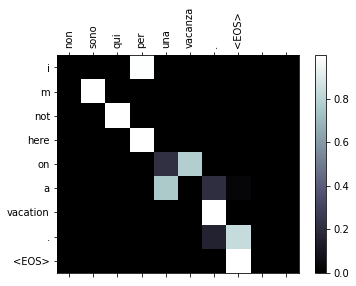

input = voi siete entrambe pazze .
output = you re both crazy . <EOS>


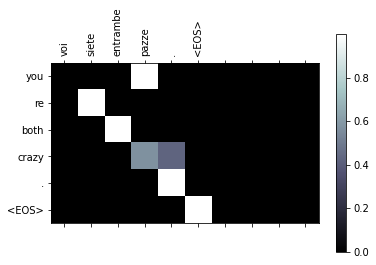

input = siamo in ritardo per colpa sua .
output = we re late because of you . <EOS>


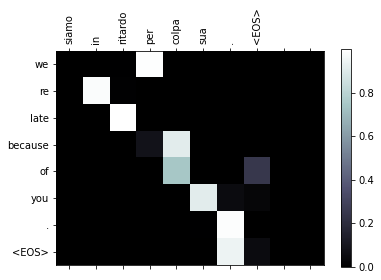

In [48]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

evaluateRandomly(encoder1, attn_decoder1)

output_words, attentions = evaluate(
    encoder1, attn_decoder1, "sono abituato ad essere ignorato .")
plt.matshow(attentions.numpy())

evaluateAndShowAttention(random.choice(pairs)[0])

evaluateAndShowAttention(random.choice(pairs)[0])

evaluateAndShowAttention(random.choice(pairs)[0])

evaluateAndShowAttention(random.choice(pairs)[0])

# Experiment 3

This time number of hidden layers are more stacked. Both encoder and decoder use more hidden layers.

4m 25s (- 61m 58s) (5000 6%) 3.0807
8m 40s (- 56m 20s) (10000 13%) 2.7115
13m 3s (- 52m 12s) (15000 20%) 2.4955
17m 25s (- 47m 56s) (20000 26%) 2.3707
21m 46s (- 43m 33s) (25000 33%) 2.2330
26m 1s (- 39m 2s) (30000 40%) 2.1395
30m 24s (- 34m 45s) (35000 46%) 2.0171
34m 46s (- 30m 25s) (40000 53%) 1.9434
39m 12s (- 26m 8s) (45000 60%) 1.8614
43m 36s (- 21m 48s) (50000 66%) 1.8145
47m 53s (- 17m 24s) (55000 73%) 1.7209
52m 10s (- 13m 2s) (60000 80%) 1.6780
56m 33s (- 8m 42s) (65000 86%) 1.6151
60m 53s (- 4m 20s) (70000 93%) 1.5800
65m 15s (- 0m 0s) (75000 100%) 1.5623
> io sono bravo con le persone .
= i m good with people .
< i m good with your . <EOS>

> sono terribilmente dispiaciuto .
= i m terribly sorry .
< i am happy . <EOS>

> io sto soltanto aspettando tom .
= i m just waiting for tom .
< i m having tom now . <EOS>

> sto cercando i miei amici .
= i am looking for my friends .
< i am waiting for my . <EOS>

> io ho solamente tredici anni .
= i m only thirteen .
< i am only thirt

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()


<Figure size 432x288 with 0 Axes>

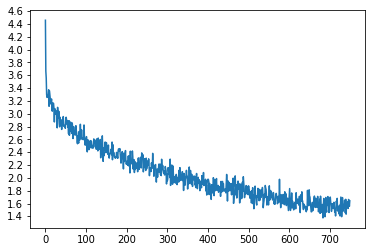

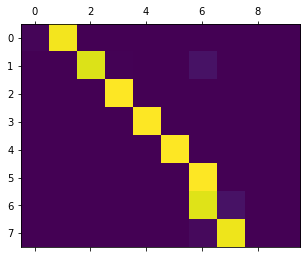

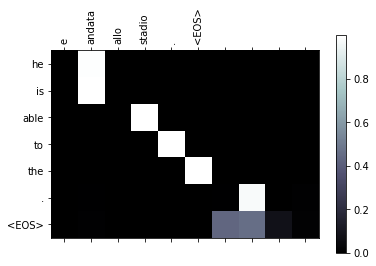

input = tu sei al sicuro con noi .
output = you re safe . <EOS>


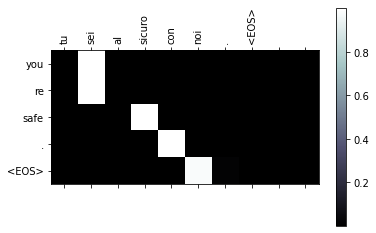

input = io sto lavorando a un grande progetto .
output = i am studying a good . <EOS>


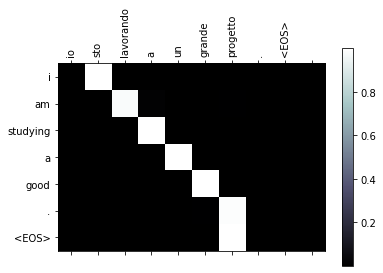

input = sto parlando con il mio alunno .
output = i am your my of my . <EOS>


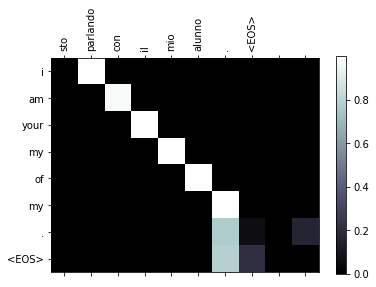

In [52]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        output, hidden = self.gru(output, hidden)
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
    
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

hidden_size = 128
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

evaluateRandomly(encoder1, attn_decoder1)

output_words, attentions = evaluate(
    encoder1, attn_decoder1, "sono abituato ad essere ignorato .")
plt.matshow(attentions.numpy())

evaluateAndShowAttention(random.choice(pairs)[0])

evaluateAndShowAttention(random.choice(pairs)[0])

evaluateAndShowAttention(random.choice(pairs)[0])

evaluateAndShowAttention(random.choice(pairs)[0])

# Experiment 4

Using higher dropout value of 0.5 and slower learning rate of 0.001.. lets see what happens. Note that I'm using the notebook default model and not my stacked model.

2m 54s (- 40m 38s) (5000 6%) 3.3022
5m 46s (- 37m 34s) (10000 13%) 2.9689
8m 43s (- 34m 54s) (15000 20%) 2.7659
11m 39s (- 32m 3s) (20000 26%) 2.5716
14m 37s (- 29m 15s) (25000 33%) 2.4330
17m 36s (- 26m 24s) (30000 40%) 2.2974
20m 35s (- 23m 32s) (35000 46%) 2.2222
23m 29s (- 20m 33s) (40000 53%) 2.1183
26m 21s (- 17m 34s) (45000 60%) 2.0286
29m 24s (- 14m 42s) (50000 66%) 1.9877
32m 20s (- 11m 45s) (55000 73%) 1.8843
35m 19s (- 8m 49s) (60000 80%) 1.8302
38m 16s (- 5m 53s) (65000 86%) 1.7560
41m 14s (- 2m 56s) (70000 93%) 1.6858
44m 8s (- 0m 0s) (75000 100%) 1.6396
> tu inganni te stesso .
= you re deluding yourself .
< you re going to the . <EOS>

> ha un umore strano oggi .
= you re in a strange mood today .
< you re a a to . . <EOS>

> voi non siete piu divertenti .
= you re no fun anymore .
< you re not longer anymore . <EOS>

> io non sono quel genere di persona .
= i m not that kind of person .
< i m not in love of the . <EOS>

> lei e priva di sensi .
= she s unconscious .
< s

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()


<Figure size 432x288 with 0 Axes>

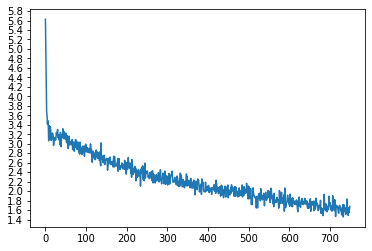

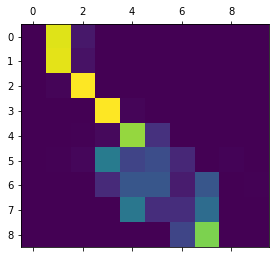

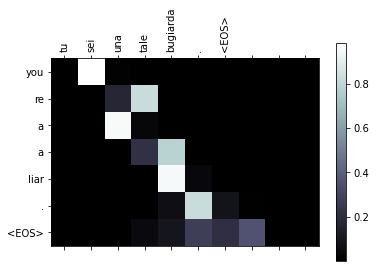

input = siamo una grande famiglia felice .
output = we re just a good happy . <EOS>


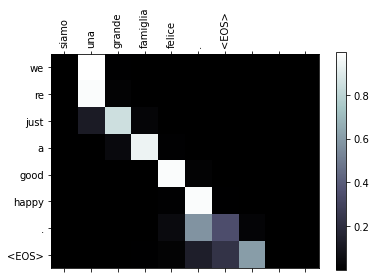

input = sono la nonna di tom .
output = i m tom s tom . <EOS>


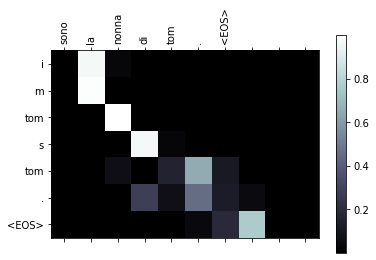

input = sono fortunata .
output = i m worried . <EOS>


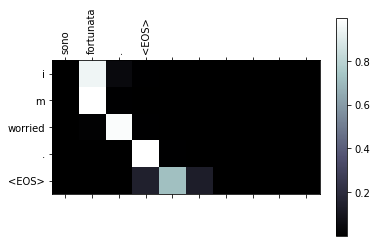

In [69]:
hidden_size = 512
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.5).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000, learning_rate=0.001)

evaluateRandomly(encoder1, attn_decoder1)

output_words, attentions = evaluate(
    encoder1, attn_decoder1, "sono abituato ad essere ignorato .")
plt.matshow(attentions.numpy())

evaluateAndShowAttention(random.choice(pairs)[0])

evaluateAndShowAttention(random.choice(pairs)[0])

evaluateAndShowAttention(random.choice(pairs)[0])

evaluateAndShowAttention(random.choice(pairs)[0])

# Experiment 5

Default network but with much slower learning rate and dropout rate of 0.2.

3m 2s (- 42m 36s) (5000 6%) 3.3618
6m 4s (- 39m 28s) (10000 13%) 2.9578
9m 5s (- 36m 23s) (15000 20%) 2.7753
12m 8s (- 33m 22s) (20000 26%) 2.6064
15m 11s (- 30m 23s) (25000 33%) 2.4995
18m 12s (- 27m 18s) (30000 40%) 2.3987
21m 12s (- 24m 13s) (35000 46%) 2.2943
24m 15s (- 21m 13s) (40000 53%) 2.2002
27m 23s (- 18m 15s) (45000 60%) 2.1683
30m 25s (- 15m 12s) (50000 66%) 2.0908
33m 25s (- 12m 9s) (55000 73%) 1.9784
36m 30s (- 9m 7s) (60000 80%) 1.9426
39m 30s (- 6m 4s) (65000 86%) 1.8730
42m 32s (- 3m 2s) (70000 93%) 1.8152
45m 35s (- 0m 0s) (75000 100%) 1.7482
> sei maturo .
= you re mature .
< you re wonderful . <EOS>

> lei sta interferendo .
= you re interfering .
< you re going . <EOS>

> loro sono dei corridori veloci .
= they re fast runners .
< they re proud of the . <EOS>

> sono cosi pieno .
= i m so full .
< i m so nervous . <EOS>

> sono fuori forma .
= i m out of shape .
< i m just hungry . <EOS>

> sei troppo alta .
= you re too tall .
< you re too old . <EOS>

> sto scri

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()


<Figure size 432x288 with 0 Axes>

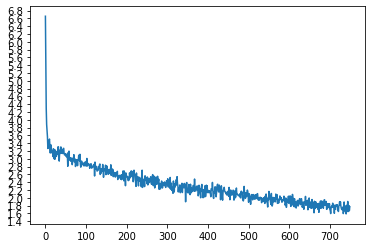

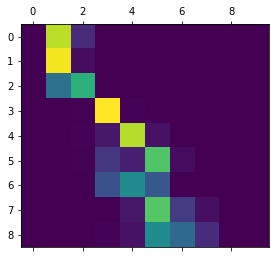

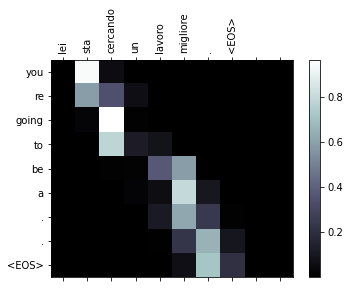

input = sono piu grossa di voi .
output = i m the than you are . <EOS>


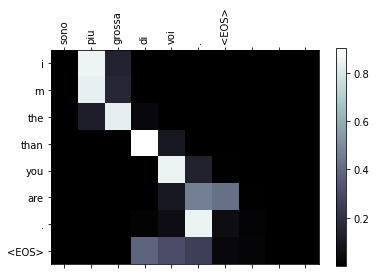

input = non te ne stai andando vero ?
output = you re not going to you you ? <EOS>


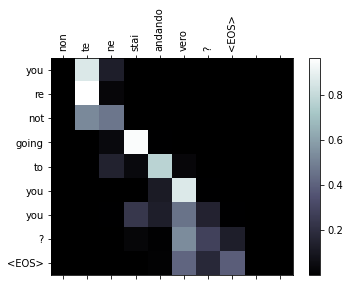

input = sono ingegnere .
output = i m nervous . <EOS>


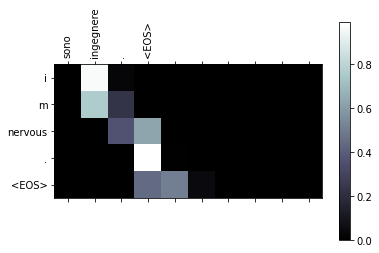

In [70]:
hidden_size = 1024
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.2).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000, learning_rate=0.0005)

evaluateRandomly(encoder1, attn_decoder1)

output_words, attentions = evaluate(
    encoder1, attn_decoder1, "sono abituato ad essere ignorato .")
plt.matshow(attentions.numpy())

evaluateAndShowAttention(random.choice(pairs)[0])

evaluateAndShowAttention(random.choice(pairs)[0])

evaluateAndShowAttention(random.choice(pairs)[0])

evaluateAndShowAttention(random.choice(pairs)[0])

# Question 3

Increase in hyper-parameters such as hidden neurons and layers obviously increases the compute cost and time. However there are some good signs of improvement while evaluating the model. This improvement can be proved by viewing the attention matrix for a given fixed Italian sentence and the loss values. As we add more parameters to the model, we can visually see the model make more connections between a word and its relevant context and these connections are improved in bigger networks. Another interesting experiment is by using high dropout rate. Higher this probability rate, higher the variance in output layer distribution. This is because we are creating maximum amount of regularization in the model. This does not necessarily mean better performance but I guess from the results, the model is maybe perfuming better than the model with dropout rate of 0.1. Lastly, the slower learning rate experiment with two sets of hidden layer sizes performs poorly than the model with faster learning rate. This could be due to being stuck in a local optima and not able to get out of it. In conclusion, model tuning and refinement is the key to obtaining better performance and is often the most challenging part of neural networks.